In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
import pandas as pd
from sklearn.model_selection import train_test_split

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = [label - 1 for label in labels]
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        # use tokenizer for words encoding
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }



train_df = pd.read_json('train_set.json')
test_df = pd.read_json('test_set.json')


train_dataset = CustomDataset(train_df['text'].tolist(), train_df['stars'].tolist(), tokenizer)
test_dataset = CustomDataset(test_df['text'].tolist(), test_df['stars'].tolist(), tokenizer)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
print(len(test_dataset))

20000


In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer

class BERTGRUSentiment(nn.Module):
    def __init__(self, bert, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()

        self.bert = bert
        embedding_dim = bert.config.to_dict()['hidden_size']

        self.rnn = nn.GRU(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout=0 if n_layers < 2 else dropout
        )

        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        with torch.no_grad():
            embedded = self.bert(text)[0]

        _, hidden = self.rnn(embedded)

        if self.rnn.bidirectional:
            hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        else:
            hidden = hidden[-1, :, :]

        hidden = self.dropout(hidden)
        output = self.out(hidden)
        return output


bert = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

model = BERTGRUSentiment(
    bert=bert,
    hidden_dim=256,
    output_dim=5,  #rating from 1-5 
    n_layers=2,
    bidirectional=True,
    dropout=0.25
)

def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
trainable_params = count_trainable_params(model)
print(f'The model has {trainable_params:,} trainable parameters.')


for name, param in model.named_parameters():
    if name.startswith('bert'):
        param.requires_grad = False


def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
trainable_params = count_trainable_params(model)
print(f'The model has {trainable_params:,} trainable parameters.')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

The model has 112,243,461 trainable parameters.
The model has 2,761,221 trainable parameters.


In [ ]:
def train(model, data_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for batch in data_loader:
        inputs, labels = batch['input_ids'], batch['labels']
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()


        _, predictions = torch.max(outputs, dim=1)
        total_correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)

    average_loss = total_loss / len(data_loader)
    accuracy = total_correct / total_samples
    return average_loss, accuracy

def evaluate(model, data_loader, criterion,device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch in data_loader:
            inputs, labels = batch['input_ids'], batch['labels']
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predictions = torch.max(outputs, dim=1)
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    average_loss = total_loss / len(data_loader)
    accuracy = total_correct / total_samples
    return average_loss, accuracy

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch: 1, Train Loss: 1.0540, Train Accuracy: 0.5374, Test Loss: 0.7655, Test Accuracy: 0.6732
Epoch: 2, Train Loss: 0.8952, Train Accuracy: 0.6069, Test Loss: 0.7174, Test Accuracy: 0.6966
Epoch: 3, Train Loss: 0.8489, Train Accuracy: 0.6280, Test Loss: 0.7756, Test Accuracy: 0.6835
Epoch: 4, Train Loss: 0.8129, Train Accuracy: 0.6448, Test Loss: 0.7356, Test Accuracy: 0.6880
Epoch: 5, Train Loss: 0.7833, Train Accuracy: 0.6579, Test Loss: 0.7868, Test Accuracy: 0.6572
Epoch: 6, Train Loss: 0.7459, Train Accuracy: 0.6752, Test Loss: 0.6967, Test Accuracy: 0.7064
Epoch: 7, Train Loss: 0.7108, Train Accuracy: 0.6923, Test Loss: 0.7797, Test Accuracy: 0.6749
Epoch: 8, Train Loss: 0.6680, Train Accuracy: 0.7123, Test Loss: 0.7514, Test Accuracy: 0.6923
Epoch: 9, Train Loss: 0.6291, Train Accuracy: 0.7354, Test Loss: 0.8342, Test Accuracy: 0.6610
Epoch: 10, Train Loss: 0.5881, Train Accuracy: 0.7497, Test Loss: 0.8014, Test Accuracy: 0.6792


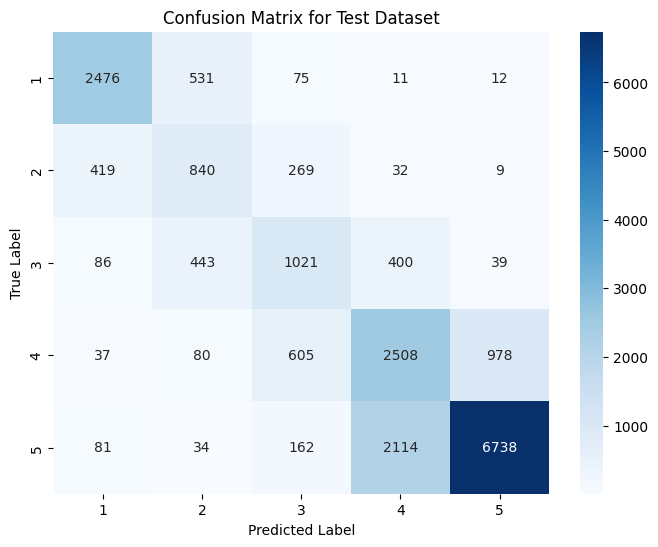

              precision    recall  f1-score   support

      Star 1       0.80      0.80      0.80      3105
      Star 2       0.44      0.54      0.48      1569
      Star 3       0.48      0.51      0.50      1989
      Star 4       0.50      0.60      0.54      4208
      Star 5       0.87      0.74      0.80      9129

    accuracy                           0.68     20000
   macro avg       0.62      0.64      0.62     20000
weighted avg       0.71      0.68      0.69     20000



In [ ]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss()
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
    print(f'Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')








import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


def get_predictions_and_labels(model, data_loader):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch in data_loader:
            inputs, labels = batch['input_ids'], batch['labels']
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            predictions = torch.argmax(outputs, dim=1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_predictions, all_labels


predictions, labels = get_predictions_and_labels(model, test_loader)


conf_matrix = confusion_matrix(labels, predictions)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 6), yticklabels=range(1, 6))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Test Dataset')
plt.show()

report = classification_report(labels, predictions, target_names=[f'Star {i}' for i in range(1, 6)])
print(report)

In [ ]:
torch.save(model.state_dict(), 'model_bert.pth')

